<a href="https://colab.research.google.com/github/arjangvt/CodeFolio/blob/main/ML/TimeSeries/AR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code demonstrates a simple AutoRegression (AR) model on a time series data set<br>
The Dataset can be found in my github repo. <br>

<br><br>
---

Written by: Arjang Fahim
Date: 12/12/2021
Last update: 5/8/2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

from google.colab import drive

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
icecream_data = "your_drive/ice_cream.csv"

# Ice Cream Production Data


In [4]:
def parser(s):
  return datetime.strptime(s, '%Y-%m-%d')

In [5]:
production_ice_cream = pd.read_csv(icecream_data, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [6]:
production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [7]:
# infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [8]:
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

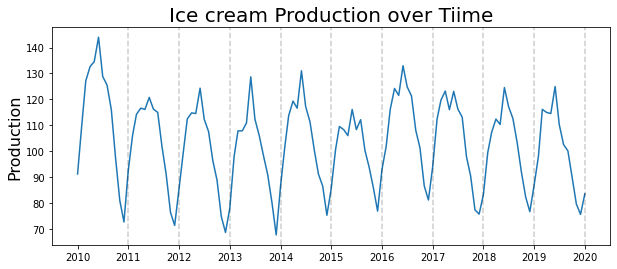

In [9]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title("Ice cream Production over Tiime", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# ACF - Auto Correlation Function

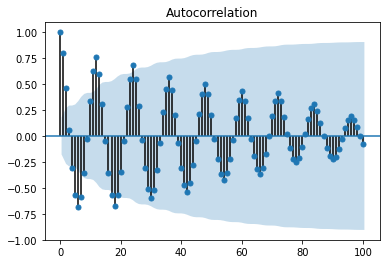

In [10]:
acf_plot = plot_acf(production_ice_cream, lags=100)

# Based on decaying ACF, we are likely dealing with an Auto Regressive process?

# PACF = Partial Auto Correlation Function

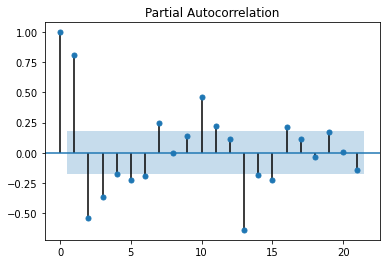

In [11]:
pacf_plot = plot_pacf(production_ice_cream)

# Based on PACF, we should start with Auto Regressive model with lags 1, 2,3, 10, 13

# Get training and testing sets

In [12]:
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

# Fit the AR Model

In [13]:
# There two parameters needs to be passed to order AR and MA. This demo is just
# for AR model so AR=3 and MA=0
# I just decided to use lagg 3 from PACF

# create the model
model = ARMA(train_data, order=(3,0))

In [14]:
# fit the mode
start = time()
model_fit = model.fit()
end = time()

print('Model fitting time:', end - start)

Model fitting time: 0.10869574546813965


In [15]:
print(model_fit.summary())

# Description:
# The second table talks about the importance of each lag, that you choose 
# to include here.
# The P value should be less than 0.05 for example from table below
# L2 with the p value of 0.696 is not important. So I prefer to build my model
# with lag1 and lag3 excluding lag2

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                     ARMA(3, 0)   Log Likelihood                -374.085
Method:                       css-mle   S.D. of innovations              7.642
Date:                Sat, 28 May 2022   AIC                            758.170
Time:                        05:34:41   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5743      1.809     57.265      0.000     100.029     107.119
ar.L1.production     1.0469      0.088     11.960      0.000       0.875       1.218
ar.L2.production    -0.0523 

In [19]:
# get prediction start and end
pred_start_date =  test_data.index[0]
pred_end_date = test_data.index[-1]

In [21]:
# get the prediction and residual
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals =  test_data - predictions

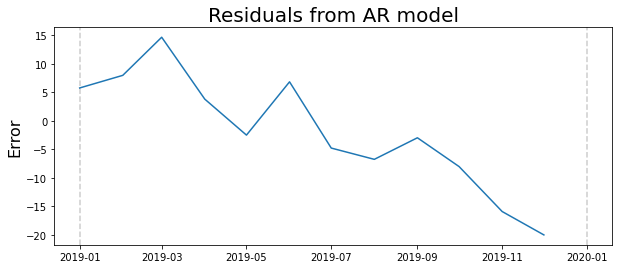

In [27]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
#plt.plot(test_data)
#plt.plot(predictions)
plt.title("Residuals from AR model", fontsize=20)
plt.ylabel("Error", fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# The result maybe centered around zero but it is decreasing. This is not typically what
# we want. There should be in the synamic of the data that we did not capture it

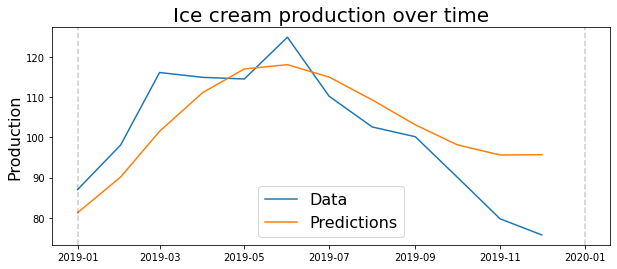

In [28]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title("Ice cream production over time", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


In [30]:
# On average what percent  we are away from our target. 
# The reseult (9%) not great and also not too bad!
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0895


In [31]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.884059498591348
